In [1]:
!pip install diffusers accelerate transformers
!pip install numpngw timm einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.9 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/IzumiSatoshi/deforumed-walk.git

Cloning into 'deforumed-walk'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 53 (delta 15), reused 45 (delta 10), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [3]:
%cd deforumed-walk/

/content/deforumed-walk


In [104]:
import sys
sys.path.append("/content/deforumed-walk/src")
from warp import AnimArgs
from depth import DepthModel
import torch
import math
import py3d_tools as p3d
from einops import rearrange
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.schedulers import DPMSolverMultistepScheduler, DDIMScheduler
from IPython import display
import time

In [5]:
def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image

def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    return new_image

In [6]:

pipe = StableDiffusionImg2ImgPipeline.from_pretrained("/content/drive/MyDrive/models/diffusers/stable_diffusion_2_1")

In [7]:
pipe = pipe.to("cuda")

In [8]:
depth_model = DepthModel(torch.device("cuda"), "/content/drive/MyDrive/AI/models/dpt_large-midas-2f21e586.pt", half_precision=True)

In [34]:
pipe.scheduler = DPMSolverMultistepScheduler.from_pretrained("/content/drive/MyDrive/models/diffusers/stable_diffusion_2_1/scheduler")

  0%|          | 0/15 [00:00<?, ?it/s]

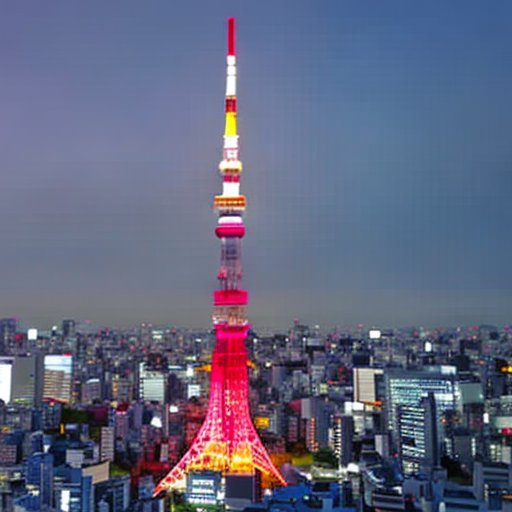

In [69]:
image

In [ ]:
max_frame = 100
prompt = "Tokyo tower"
strength = 0.2

prev_img = None
for frame in range(max_frame):
  transformed_prev_img = transform_prev_img(prev_img)
  image = pipe(prompt, transformed_prev_img)
  

In [71]:
depth = depth_model.predict(image)

In [ ]:
def t2i():
  pipe.scheduler = DPMSolverMultistepScheduler.from_pretrained("/content/drive/MyDrive/models/diffusers/stable_diffusion_2_1/scheduler")
  positive_prompt = "Tokyo Tower photo from sky,at night, Center Composition, 4k, UHD, high quality, drone footage"
  negative_prompt = "low quality, low resolution, blurry image"
  seed = 0
  step = 15
  torch.manual_seed(seed)
  # is this correct way to t2i? init image affects alot.
  image = pipe(
      prompt=positive_prompt, 
      image=PIL.Image.fromarray(np.full((512,512,3),120, dtype=np.uint8)), 
      strength=1, 
      negative_prompt=negative_prompt,
      num_inference_steps=step,
  ).images[0]
  return image

In [108]:
def i2i(init_image):
  global pipe
  pipe.scheduler = DPMSolverMultistepScheduler.from_pretrained("/content/drive/MyDrive/models/diffusers/stable_diffusion_2_1/scheduler")
  # Why does i2i degrade image quality?
  positive_prompt = "Tokyo Tower photo from sky,at night, Center Composition, 4k, UHD, high quality, drone footage"
  negative_prompt = "low quality, low resolution, blurry image"
  seed = 0
  step = 15
  strength = 0.7
  torch.manual_seed(seed)
  image = pipe(
      prompt=positive_prompt, 
      image=init_image, 
      strength=strength, 
      negative_prompt=negative_prompt,
      num_inference_steps=step,
  ).images[0]
  return image

prev


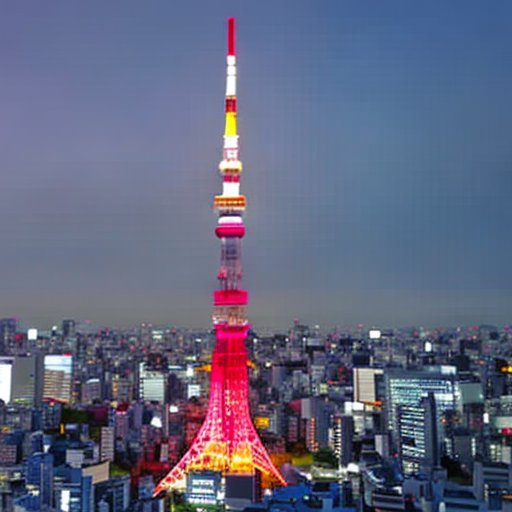

result


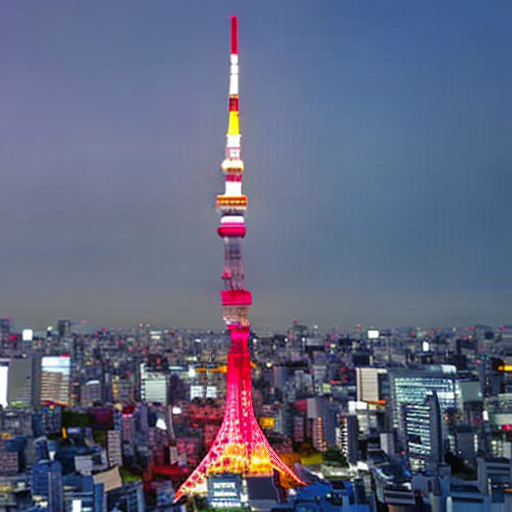

In [88]:
device = torch.device("cuda")

# calibration steps
# 1. Set phi so that the horizon is in the middle of the screen.
# 2. Adjust radius so that the object stays in the center of the screen even with a large value in theta.
# 3. Adjust theita large enough that the three-dimensional expression of the rotation is not lost, and small enough that the shape is not too distorted.
def transform_prev_img(prev_img: PIL.Image, depth: torch.Tensor, device) -> PIL.Image:
    near=200,
    far=10_000,
    fov_deg=40,
    padding_mode="border"
    sampling_mode="bicubic"

    frame_idx = 0
    prev_img_cv2 = pil2cv(prev_img)
    depth_tensor = depth

    # no translate scale
    theita_rad = math.radians(3) # amount of move camera left
    phi_rad = math.radians(-5) # angle between camera and ground 

    radius = 2.5

    # x-> move camera left
    # y-> move camera up
    # z -> move camera backward :why?
    translate_xyz = [
        radius * np.sin(theita_rad),
        0,
        - (radius - radius * np.cos(theita_rad)),
    ]
    """
    translate_xyz = [
        0,
        0,
        0,
    ]
    """ 

    # x -> look up
    # y -> look right
    # z -> counterclockwise

    # rotate 1 : make camera parallel to ground
    rotate_xyz_1 = [
        phi_rad,
        0,
        0,
    ]
    rot_mat_1 = p3d.euler_angles_to_matrix(
        torch.tensor(rotate_xyz_1, device=device), "XYZ"
    ).unsqueeze(0)

    # rotate 2: make camera look right
    rotate_xyz_2 = [
        0,
        theita_rad,
        0,
    ]
    rot_mat_2 = p3d.euler_angles_to_matrix(
        torch.tensor(rotate_xyz_2, device=device), "XYZ"
    ).unsqueeze(0)

    # rotate 3: make camera angle original
    rotate_xyz_3 = [
        -phi_rad,
        0,
        0,
    ]
    rot_mat_3 = p3d.euler_angles_to_matrix(
        torch.tensor(rotate_xyz_3, device=device), "XYZ"
    ).unsqueeze(0)


    rot_mat =  rot_mat_1 @ rot_mat_2 @ rot_mat_3 # from right or left, seems from right is working
    # transform_image_3d
    torch.cuda.empty_cache()

    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion
    w, h = prev_img_cv2.shape[1], prev_img_cv2.shape[0]
    aspect_ratio = float(w) / float(h)
    persp_cam_old = p3d.FoVPerspectiveCameras(
        near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device
    )
    persp_cam_new = p3d.FoVPerspectiveCameras(
        near,
        far,
        aspect_ratio,
        fov=fov_deg,
        degrees=True,
        R=rot_mat,
        T=torch.tensor([translate_xyz]),
        device=device,
    )
    # range of [-1,1] is important to torch grid_sample's padding handling
    y, x = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, dtype=torch.float32, device=device),
        torch.linspace(-1.0, 1.0, w, dtype=torch.float32, device=device),
    )
    if depth_tensor is None:
        z = torch.ones_like(x)
    else:
        z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor(
        [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], device=device
    ).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(
        identity_2d_batch, [1, 1, h, w], align_corners=False
    )
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h, w, 2)).unsqueeze(0)
    image_tensor = rearrange(
        torch.from_numpy(prev_img_cv2.astype(np.float32)), "h w c -> c h w"
    ).to(device)
    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1 / 512 - 0.0001).unsqueeze(0),
        offset_coords_2d,
        mode=sampling_mode,
        padding_mode=padding_mode,
        align_corners=False,
    )
    # convert back to cv2 style numpy array
    result_cv2 = (
        rearrange(new_image.squeeze().clamp(0, 255), "c h w -> h w c")
        .cpu()
        .numpy()
        .astype(prev_img_cv2.dtype)
    )
    result = PIL.Image.fromarray(cv2.cvtColor(result_cv2, cv2.COLOR_BGR2RGB))
    return result
result = transform_prev_img(image, depth, device)
print("prev")
display.display(image)
print("result")
display.display(result)

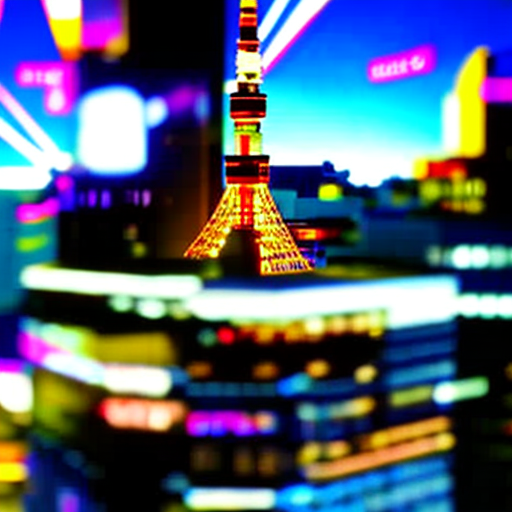

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [111]:
max_frames = 360
prev_img = image
folder_path = "/content/drive/MyDrive/Project/deforumed_walk/rotate_tower"
prev_img.save(f"{folder_path}/{0}.png")
display.display(prev_img)
for i in range(1, max_frames):
  prev_depth = depth_model.predict(prev_img)
  transformed_prev_img = transform_prev_img(prev_img, prev_depth, device)

  next_img = i2i(transformed_prev_img)
  
  next_img.save(f"{folder_path}/{i}.png")
  display.clear_output(wait=True)
  display.display(next_img)

  prev_img = next_img

In [114]:
!echo $folder_path/hoge

/content/drive/MyDrive/Project/deforumed_walk/rotate_tower/hoge


In [129]:
import glob 
paths = glob.glob(f"{folder_path}/*.png")

CLIP_FPS = 2
filepath = "/content/drive/MyDrive/Project/deforumed_walk/out.mp4"
codec = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(filepath, codec, CLIP_FPS, (512,512))

for img_file in paths:
    img = cv2.imread(img_file)
    video.write(img)

video.release()